## Selected Zones

We focus on a diverse set of European bidding zones to capture different market fundamentals (Hydro, Wind, Solar).

| Country | Zone | Code | Description |
|---|---|---|---|
| Spain | **ES** | 10YES-REE------0 | Spain (Solar-heavy, distinct daily profile) |
| Norway | **NO2** | 10YNO-2--------T | Southern Norway (Hydro, main interconnector hub) |
| Norway | **NO4** | 10YNO-4--------9 | Northern Norway (Hydro, arctic conditions) |
| Denmark | **DK1** | 10YDK-1--------W | West Denmark (Wind-heavy, continental connection) |

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
import xml.etree.ElementTree as ET
from dotenv import load_dotenv
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# Load API Token from secrets
SECRETS_PATH = Path('../../config/secrets.env')
load_dotenv(SECRETS_PATH)

ENTSOE_TOKEN = os.getenv('ENTSOE_TOKEN')

if not ENTSOE_TOKEN:
    raise ValueError("ENTSOE_TOKEN is not in secrets.env!")

# Configuration: 4 Zones
ZONES = {
    'ES': '10YES-REE------0',   # Spain
    'NO2': '10YNO-2--------T',  # Norway South (Kristiansand/Stavanger)
    'NO4': '10YNO-4--------9',  # Norway North (Tromsø)
    'DK1': '10YDK-1--------W'   # Denmark West
}

# Data directory (Project Root)
DATA_DIR = Path('../../data') 
RAW_DIR = DATA_DIR / 'raw'
RAW_DIR.mkdir(exist_ok=True, parents=True)

# Time period: 10 years (3650 days)
DAYS_BACK = 3650 

print(f"Configuration loaded:")
print(f"  Zones: {len(ZONES)} ({list(ZONES.keys())})")
print(f"  Period: {DAYS_BACK} days")
print(f"  Output: {RAW_DIR.resolve()}")

Configuration loaded:
  Zones: 4 (['ES', 'NO2', 'NO4', 'DK1'])
  Period: 3650 days
  Output: C:\Users\maxim\Projects\DsLab25W_marbl.energy\data\raw


## Data Collection Functions

Following best practices from academic literature on electricity price data processing.
This function handles dynamic resolution switching (e.g., 60min to 15min) to ensure correct timestamp alignment.

In [3]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import time
from datetime import timedelta, timezone

def fetch_entsoe_prices(zone_code, start_date, end_date, token, max_retries=3):
    """
    Fetch day-ahead electricity prices from ENTSO-E Transparency Platform.
    Logic:
    1. Requests Document A44 (Price Document).
    2. Filters by processType='A01' (Day ahead) to avoid Intraday data.
    3. Parses XML and handles variable resolutions (15m/60m).
    """
    url = 'https://web-api.tp.entsoe.eu/api'
    
    params = {
        'securityToken': token,
        'documentType': 'A44',  # Price Document
        'processType': 'A01',   # STRICTLY Day Ahead data
        'in_Domain': zone_code,
        'out_Domain': zone_code,
        'periodStart': start_date.strftime('%Y%m%d%H%M'),
        'periodEnd': end_date.strftime('%Y%m%d%H%M')
    }
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, params=params, timeout=30)
            
            if response.status_code == 200:
                try:
                    root = ET.fromstring(response.text)
                except ET.ParseError:
                    print(f"    Error parsing XML response")
                    return pd.DataFrame()

                ns = {'ns': 'urn:iec62325.351:tc57wg16:451-3:publicationdocument:7:3'}
                data = []
                
                for timeseries in root.findall('.//ns:TimeSeries', ns):
                    for period in timeseries.findall('.//ns:Period', ns):
                        start_str = period.find('.//ns:timeInterval/ns:start', ns).text
                        start_dt = pd.to_datetime(start_str).replace(tzinfo=timezone.utc)
                        
                        resolution_code = period.find('.//ns:resolution', ns).text
                        
                        if resolution_code == 'PT60M':
                            delta = timedelta(hours=1)
                        elif resolution_code == 'PT30M':
                            delta = timedelta(minutes=30)
                        elif resolution_code == 'PT15M':
                            delta = timedelta(minutes=15)
                        else:
                            continue 

                        for point in period.findall('.//ns:Point', ns):
                            position = int(point.find('.//ns:position', ns).text)
                            price_elem = point.find('.//ns:price.amount', ns)
                            
                            if price_elem is not None:
                                price = float(price_elem.text)
                                timestamp = start_dt + (position - 1) * delta
                                
                                data.append({
                                    'timestamp': timestamp,
                                    'price_eur_mwh': price
                                })
                
                if data:
                    df = pd.DataFrame(data)
                    df = df.sort_values('timestamp').drop_duplicates(subset=['timestamp'], keep='last')
                    return df.reset_index(drop=True)
                else:
                    return pd.DataFrame()
                    
            elif response.status_code == 429:
                wait_time = 60 * (attempt + 1)
                print(f"    Rate limit hit, waiting {wait_time}s...")
                time.sleep(wait_time)
            else:
                if 400 <= response.status_code < 500:
                     return pd.DataFrame()
                print(f"    Server Error {response.status_code}")

        except Exception as e:
            print(f"    Attempt {attempt + 1} failed: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(5)
    
    return pd.DataFrame()


def fetch_in_chunks(zone_code, start_date, end_date, token, chunk_days=10):
    """
    Fetch data in small chunks to ensure stability.
    """
    all_data = []
    current_start = start_date
    
    while current_start < end_date:
        current_end = min(current_start + timedelta(days=chunk_days), end_date)
        # Only print start of month to reduce noise
        if current_start.day == 1 and current_start.hour == 0: 
            print(f"    Processing: {current_start.strftime('%Y-%m')}")
        
        chunk_data = fetch_entsoe_prices(zone_code, current_start, current_end, token)
        
        if not chunk_data.empty:
            all_data.append(chunk_data)
        
        current_start = current_end
        time.sleep(0.1)
    
    if all_data:
        combined = pd.concat(all_data, ignore_index=True)
        combined = combined.sort_values('timestamp').drop_duplicates(subset=['timestamp'], keep='last')
        return combined.reset_index(drop=True)
    else:
        return pd.DataFrame()

print("Functions defined: fetch_entsoe_prices AND fetch_in_chunks.")

Functions defined: fetch_entsoe_prices AND fetch_in_chunks.


## Collection Process

Collecting 10 years of data for each zone

In [4]:
import pandas as pd
from datetime import datetime, timedelta, timezone
from pathlib import Path
import os

# 1. Setup Paths
if 'RAW_DIR' not in locals():
    DATA_DIR = Path('../../data')
    RAW_DIR = DATA_DIR / 'raw'
    RAW_DIR.mkdir(exist_ok=True, parents=True)

# 2. Helper: Load Manual ES 2025 Data
def load_manual_es_2025():
    manual_filename = "GUI_ENERGY_PRICES_202501010000-202601010000.csv"
    manual_path = RAW_DIR / manual_filename
    
    if not manual_path.exists():
        print(f"  [!] CRITICAL: Manual file not found: {manual_filename}")
        return pd.DataFrame()
    
    print(f"  Loading manual file: {manual_filename}...")
    try:
        df = pd.read_csv(manual_path)
        
        # 1. Parse Time: "31/12/2024 23:00:00 - ..."
        # The header is "MTU (UTC)"
        df['time_str'] = df['MTU (UTC)'].str.split(' - ').str[0]
        
        # 2. Convert to Datetime (DD/MM/YYYY format)
        df['timestamp'] = pd.to_datetime(df['time_str'], dayfirst=True)
        
        # 3. Set Timezone to UTC
        df['timestamp'] = df['timestamp'].dt.tz_localize('UTC')
        
        # 4. Extract Price
        target_col = 'Day-ahead Price (EUR/MWh)'
        df = df.dropna(subset=[target_col])
        df = df.rename(columns={target_col: 'price_eur_mwh'})
        
        # 5. Filter: Keep data starting from the exact handover hour
        # The API stops at 2024-12-31 23:00:00 (Exclusive).
        # So we need the manual file to START exactly at or after that.
        # (2024-12-31 23:00:00 UTC is 2025-01-01 00:00:00 CET)
        cutoff = pd.Timestamp("2024-12-31 23:00:00", tz="UTC")
        df = df[df['timestamp'] >= cutoff]
        
        print(f"  -> Successfully loaded {len(df)} rows from manual CSV.")
        return df[['timestamp', 'price_eur_mwh']].sort_values('timestamp')
        
    except Exception as e:
        print(f"  Error processing manual file: {e}")
        return pd.DataFrame()

# 3. Main Collection Loop
# -----------------------
end_date_api = datetime.now(timezone.utc)
start_date_api = end_date_api - timedelta(days=3650) 

print(f"Processing Zones...")
print("="*70)

for zone_name, zone_code in ZONES.items():
    print(f"\n{zone_name}:")
    print("-" * 40)
    
    if zone_name == 'ES':
        print("  Strategy: Hybrid (API < 2025 | Manual CSV >= 2025)")
        
        # A. Fetch History via API (Stop exactly at end of 2024)
        cutoff_date = datetime(2024, 12, 31, 23, 0, 0, tzinfo=timezone.utc)
        
        print(f"  1. Fetching API history (2015 - 2024)...")
        try:
            df_history = fetch_in_chunks(zone_code, start_date_api, cutoff_date, ENTSOE_TOKEN)
            print(f"     API returned {len(df_history)} rows.")
        except NameError:
            print("     ERROR: Functions not defined. Run Cell 3 first!")
            break

        # B. Load Manual 2025 Data
        print(f"  2. Loading Manual 2025 Data...")
        df_2025 = load_manual_es_2025()
        
        if df_2025.empty:
            print("     [!] WARNING: Manual data failed. Result will end in 2024.")
            df = df_history
        else:
            # C. Combine
            df = pd.concat([df_history, df_2025], ignore_index=True)
            print(f"  -> Merged Total: {len(df)} rows.")
            
    else:
        # Standard API for other zones
        try:
            df = fetch_in_chunks(zone_code, start_date_api, end_date_api, ENTSOE_TOKEN)
        except NameError:
            break

    # Final Processing & Saving
    if not df.empty:
        df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
        df = df.sort_values('timestamp').drop_duplicates(subset=['timestamp'], keep='last')
        
        filepath = RAW_DIR / f"{zone_name}_raw.csv"
        df.to_csv(filepath, index=False)
        
        # Check last entry
        last_entry = df.iloc[-1]
        print(f"  Saved to: {filepath.name}")
        print(f"  First: {df.iloc[0]['timestamp']}")
        print(f"  Last:  {last_entry['timestamp']} (Price: {last_entry['price_eur_mwh']})")
    else:
        print(f"  FAILED: No data available.")

print("\n" + "="*70)
print("COLLECTION COMPLETE")
print("="*70)

Processing Zones...

ES:
----------------------------------------
  Strategy: Hybrid (API < 2025 | Manual CSV >= 2025)
  1. Fetching API history (2015 - 2024)...
     API returned 75714 rows.
  2. Loading Manual 2025 Data...
  Loading manual file: GUI_ENERGY_PRICES_202501010000-202601010000.csv...
  -> Successfully loaded 31680 rows from manual CSV.
  -> Merged Total: 107394 rows.
  Saved to: ES_raw.csv
  First: 2015-11-28 23:00:00+00:00
  Last:  2025-11-26 22:45:00+00:00 (Price: 82.5)

NO2:
----------------------------------------
  Saved to: NO2_raw.csv
  First: 2015-11-28 23:00:00+00:00
  Last:  2025-11-26 22:45:00+00:00 (Price: 74.16)

NO4:
----------------------------------------
  Saved to: NO4_raw.csv
  First: 2015-11-28 23:00:00+00:00
  Last:  2025-11-26 22:45:00+00:00 (Price: 9.99)

DK1:
----------------------------------------
  Saved to: DK1_raw.csv
  First: 2015-11-28 23:00:00+00:00
  Last:  2025-11-26 22:45:00+00:00 (Price: 82.0)

COLLECTION COMPLETE


## Visual Inspection (Price History)

We plot the raw time series to visually check for:
1.  **Structural breaks:** Did the price level change drastically? (e.g. 2022 crisis)
2.  **Seasonality:** Are there visible winter peaks?
3.  **Outliers:** Are there extreme spikes or negative prices?

Plotting Price Trends...


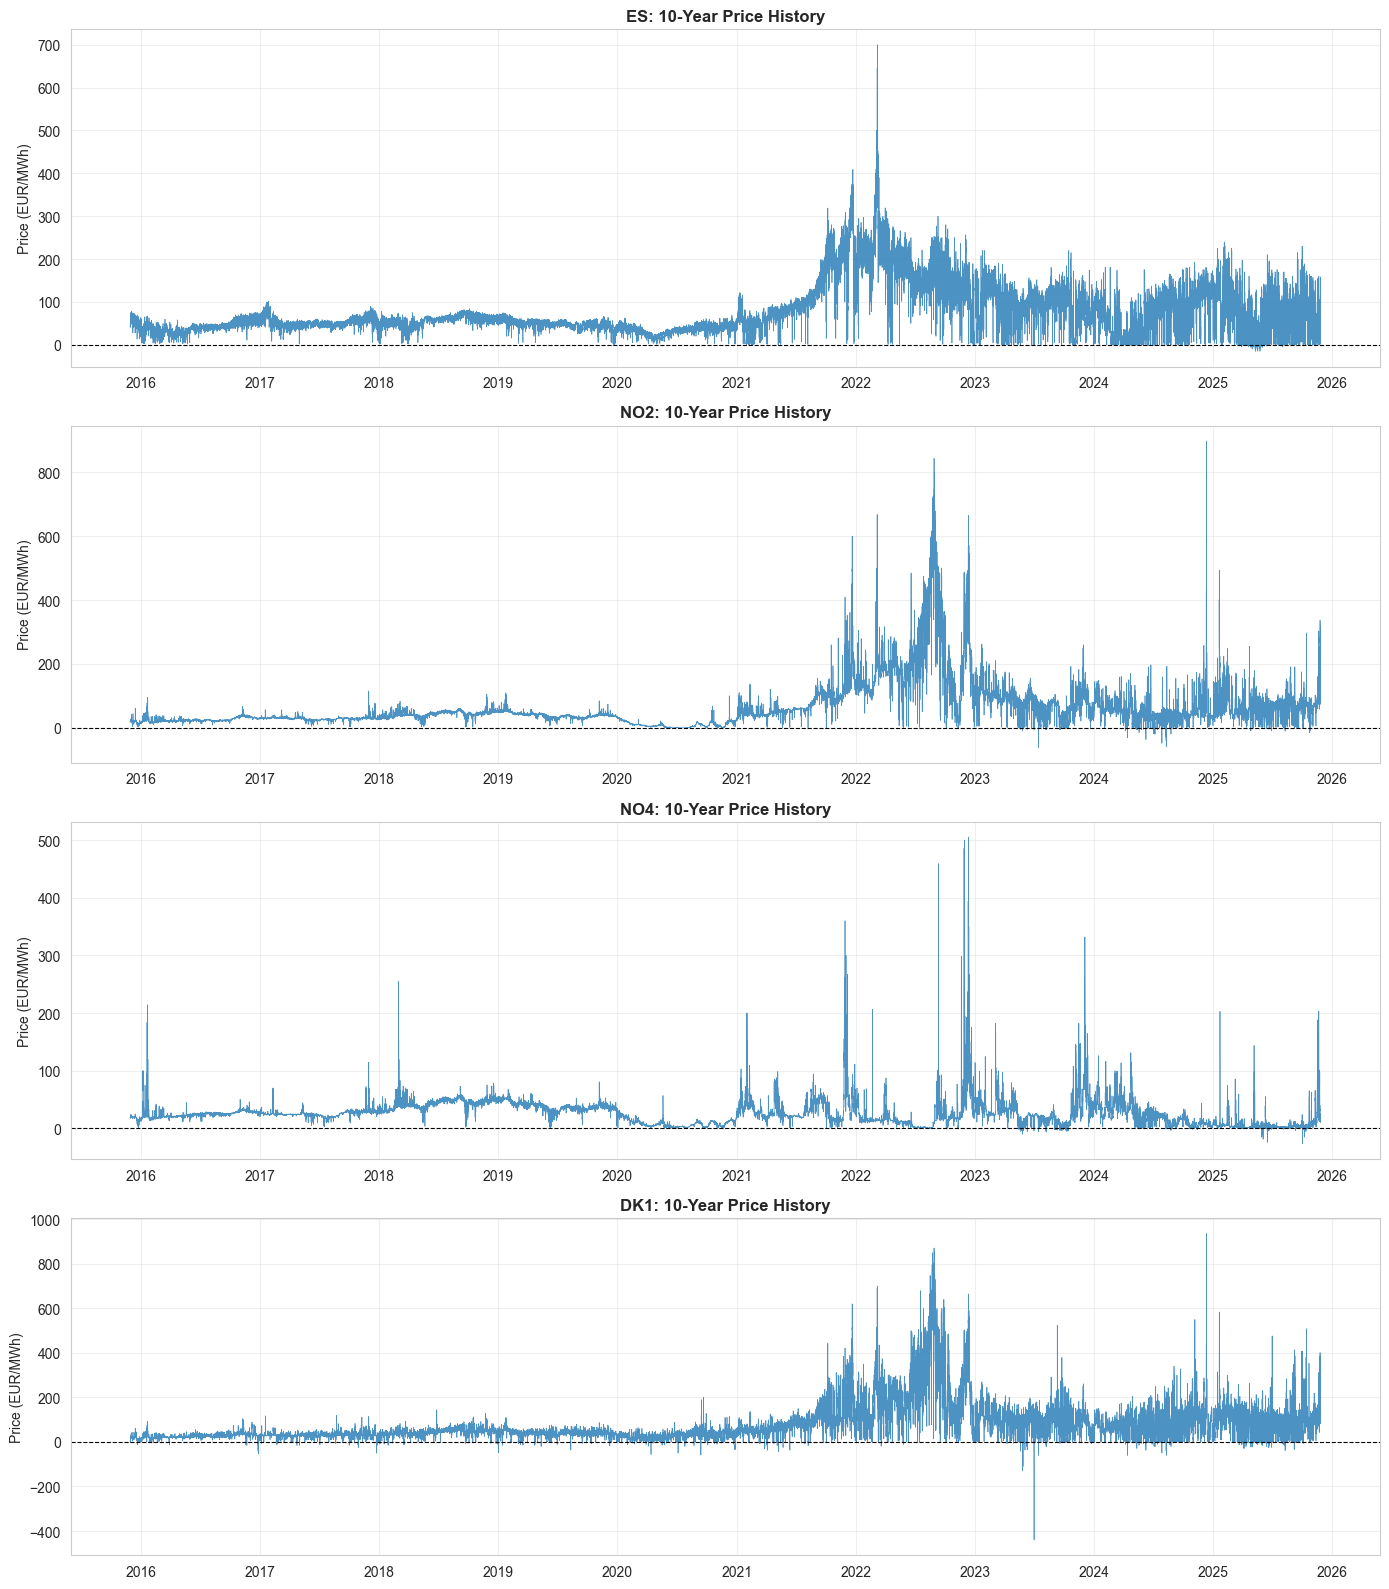

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set plot style
sns.set_style('whitegrid')

# Ensure zones variable is available
zones_to_plot = ZONES.keys() if 'ZONES' in locals() else ['ES', 'NO2', 'NO4', 'DK1']

# Create subplots
fig, axes = plt.subplots(len(zones_to_plot), 1, figsize=(14, 4 * len(zones_to_plot)))
if len(zones_to_plot) == 1:
    axes = [axes]

print("Plotting Price Trends...")

for idx, zone in enumerate(zones_to_plot):
    file_path = RAW_DIR / f"{zone}_raw.csv"
    
    if file_path.exists():
        df_plot = pd.read_csv(file_path)
        df_plot['timestamp'] = pd.to_datetime(df_plot['timestamp'], utc=True)
        df_plot = df_plot.sort_values('timestamp')
        
        # Plot
        axes[idx].plot(df_plot['timestamp'], df_plot['price_eur_mwh'], 
                       linewidth=0.5, alpha=0.8, color='#1f77b4')
        
        axes[idx].set_title(f'{zone}: 10-Year Price History', fontweight='bold')
        axes[idx].set_ylabel('Price (EUR/MWh)')
        axes[idx].grid(True, alpha=0.3)
        
        # Highlight 0 line for negative prices
        axes[idx].axhline(0, color='black', linewidth=0.8, linestyle='--')
    else:
        axes[idx].text(0.5, 0.5, 'Data not found', ha='center', va='center')

plt.tight_layout()
plt.show()

## Detailed Gap Report
This analysis locates specific missing data blocks.
* **Sporadic:** Single missing hours (Easy to fix via interpolation).
* **Consecutive:** Blocks of missing hours (Requires attention).
* **Output:** A specific list of "Bad Gaps" (if any) and their dates.

In [6]:
import pandas as pd
from pathlib import Path
from datetime import timedelta

# Ensure paths are defined
if 'RAW_DIR' not in locals():
    DATA_DIR = Path('../../data')
    RAW_DIR = DATA_DIR / 'raw'

def report_gap_details(zone_name):
    file_path = RAW_DIR / f"{zone_name}_raw.csv"
    if not file_path.exists():
        return

    # 1. Load and Standardize to Hourly
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df = df.set_index('timestamp').sort_index()
    
    # Normalize to hourly master index to detect gaps
    # (If a 15min value exists in an hour, that hour is considered "Present")
    df_hourly = df.resample('1H').first()
    
    # Create the perfect timeline
    full_range = pd.date_range(df_hourly.index.min(), df_hourly.index.max(), freq='h')
    df_full = df_hourly.reindex(full_range)
    
    # 2. Identify Gaps
    # 'is_na' is True if the hour is missing
    if 'price_eur_mwh' in df_full.columns:
        is_na = df_full['price_eur_mwh'].isna()
    else:
        is_na = df_full.iloc[:, 0].isna()

    # 3. Group Consecutive Gaps
    # This logic assigns a unique ID to each block of consecutive NaNs
    gap_groups = (is_na != is_na.shift()).cumsum()
    
    # Filter only the NaN groups
    gap_stats = df_full[is_na].groupby(gap_groups)
    
    # 4. Calculate Duration of each gap
    # We extract Start Time, End Time, and Count (Duration)
    gaps_df = pd.DataFrame({
        'start': gap_stats.apply(lambda x: x.index[0]),
        'end': gap_stats.apply(lambda x: x.index[-1]),
        'hours_missing': gap_stats.size()
    })

    # 5. Generate Report
    print(f"\n=== {zone_name} DETAILED GAP REPORT ===")
    
    single_gaps = len(gaps_df[gaps_df['hours_missing'] == 1])
    multi_gaps = len(gaps_df[gaps_df['hours_missing'] > 1])
    structural_gaps = len(gaps_df[gaps_df['hours_missing'] > 24])
    
    print(f"Total distinct gap events: {len(gaps_df)}")
    print(f"  - Single hour gaps (Easy interpolation): {single_gaps}")
    print(f"  - Multi-hour gaps (2-24h): {multi_gaps - structural_gaps}")
    print(f"  - Structural gaps (>24h): {structural_gaps}")
    
    # 6. Show "Bad" Gaps (if any)
    if structural_gaps > 0:
        print("\n  [!] ATTENTION NEEDED - Gaps > 24 Hours:")
        bad_gaps = gaps_df[gaps_df['hours_missing'] > 24].sort_values('hours_missing', ascending=False)
        print(bad_gaps[['start', 'end', 'hours_missing']].to_string(index=False))
    
    # 7. Show a few multi-hour gaps (if no structural ones exist, just to see)
    elif multi_gaps > 0:
        print("\n  Top 5 longest gaps (under 24h):")
        print(gaps_df.sort_values('hours_missing', ascending=False).head(5).to_string(index=False))
    else:
        print("\n  Status: Excellent continuity.")

# Execute for all zones
for zone in ZONES.keys():
    report_gap_details(zone)


=== ES DETAILED GAP REPORT ===
Total distinct gap events: 2977
  - Single hour gaps (Easy interpolation): 2429
  - Multi-hour gaps (2-24h): 548
  - Structural gaps (>24h): 0

  Top 5 longest gaps (under 24h):
                    start                       end  hours_missing
2024-03-10 00:00:00+00:00 2024-03-10 17:00:00+00:00             18
2019-12-21 01:00:00+00:00 2019-12-21 17:00:00+00:00             17
2023-11-05 01:00:00+00:00 2023-11-05 15:00:00+00:00             15
2023-01-01 00:00:00+00:00 2023-01-01 11:00:00+00:00             12
2024-04-08 23:00:00+00:00 2024-04-09 08:00:00+00:00             10

=== NO2 DETAILED GAP REPORT ===
Total distinct gap events: 1214
  - Single hour gaps (Easy interpolation): 1068
  - Multi-hour gaps (2-24h): 146
  - Structural gaps (>24h): 0

  Top 5 longest gaps (under 24h):
                    start                       end  hours_missing
2020-07-14 06:00:00+00:00 2020-07-14 14:00:00+00:00              9
2024-04-07 01:00:00+00:00 2024-04-07 06:00:

## Price Distribution Analysis
We quantify zero and negative prices to validate market fundamentals.
* **Negative Prices:** Expected in renewable-heavy zones (e.g., DK1, ES).
* **Zero Prices:** Can be valid market results or indicate data gaps.

In [7]:
import pandas as pd
from pathlib import Path

# Ensure paths are defined
if 'RAW_DIR' not in locals():
    DATA_DIR = Path('../../data')
    RAW_DIR = DATA_DIR / 'raw'

def check_price_distribution(zone_name):
    """
    Quantify zero and negative prices.
    Negative prices are valid in renewable-heavy markets.
    """
    file_path = RAW_DIR / f"{zone_name}_raw.csv"
    if not file_path.exists():
        print(f"Skipping {zone_name} (not found)")
        return
    
    df = pd.read_csv(file_path)
    total = len(df)
    
    if total > 0:
        zeros = (df['price_eur_mwh'] == 0.0).sum()
        negatives = (df['price_eur_mwh'] < 0).sum()
        
        print(f"{zone_name}:")
        print(f"  Zero prices: {zeros:,} ({100*zeros/total:.2f}%)")
        print(f"  Negative prices: {negatives:,} ({100*negatives/total:.2f}%)")
    else:
        print(f"{zone_name}: File is empty.")

print("\nPrice Distribution Analysis:")
print("=" * 50)

# Use ZONES from config, or fallback list
zones_to_check = ZONES.keys() if 'ZONES' in locals() else ['ES', 'NO2', 'NO4', 'DK1']

for zone in zones_to_check:
    check_price_distribution(zone)


Price Distribution Analysis:
ES:
  Zero prices: 1,194 (1.11%)
  Negative prices: 2,384 (2.22%)
NO2:
  Zero prices: 40 (0.04%)
  Negative prices: 436 (0.48%)
NO4:
  Zero prices: 88 (0.10%)
  Negative prices: 695 (0.79%)
DK1:
  Zero prices: 173 (0.19%)
  Negative prices: 1,818 (1.99%)
